In [1]:
import seqdata as sd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
path_out = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/report/SC.delta/outs"

In [2]:
path_sdata = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/outs/SC.delta.sample.full.seqdata"

In [3]:
sdata = sd.open_zarr(path_sdata)

In [4]:
seq_df = sdata[["chrom", "chromStart", "chromEnd", "type", "length", "gc_percent", "total_counts"]].to_dataframe()
char_df = sdata["alphabet_cnt"].to_dataframe().reset_index()
char_df["_alphabet"]=char_df["_alphabet"].astype(str)
char_df = char_df.pivot(index="_sequence", columns="_alphabet", values="alphabet_cnt")
char_df["non_alphabet_cnt"] = sdata["non_alphabet_cnt"].values
char_df = char_df.div(sdata["length"].values, axis=0)
assert np.allclose(char_df.sum(axis=1), 1)
seq_df = pd.concat([seq_df, char_df], axis=1)
seq_df.head()

,chrom,chromStart,chromEnd,type,length,gc_percent,total_counts,A,C,G,T,non_alphabet_cnt
_sequence,,,,,,,,,,,,
region_0,chr1,1832106,1835244,region,2114,0.467833,42.0,0.301798,0.242195,0.225639,0.230369,0.0
region_1,chr1,1942591,1945729,region,2114,0.598865,102.0,0.194418,0.313150,0.285714,0.206717,0.0
region_2,chr1,2545461,2548599,region,2114,0.683538,154.0,0.150426,0.314570,0.368969,0.166036,0.0
region_3,chr1,3939040,3942178,region,2114,0.533586,22.0,0.236518,0.260170,0.273415,0.229896,0.0
region_4,chr1,9003727,9006865,region,2114,0.542100,29.0,0.235572,0.261116,0.280984,0.222327,0.0


# SeqData

In [20]:
import plotly.graph_objects as go
import numpy as np

def plotly_tracks(
    tracks, 
    interval, 
    height=1.5, 
    colors=None
):
    # Create a figure object
    fig = go.Figure()
    
    x = np.linspace(interval["start"], interval["end"], num=len(next(iter(tracks.values()))))
    
    # Add each track to the figure
    for title, y in tracks.items():
        color = colors[title] if colors else None
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                fill='tozeroy',
                name=title,
                line=dict(color=color) if color else None
            )
        )
    
    # Set axis labels and layout
    fig.update_layout(
        title="Tracks",
        xaxis_title=f"{interval['chrom']}:{interval['start']}-{interval['end']}",
        yaxis_title="Value",
        height=height * 300,  # Adjust height dynamically
        template="simple_white",
        showlegend=True
    )
    
    return fig

In [21]:
# Example usage


# Mock data for testing
np.random.seed(42)
preds = np.random.rand(100)
trues = np.random.rand(100)
chrom = "chr1"
chromStart = 10000
chromEnd = 10100

interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "Predicted": preds,
    "Observed": trues,
}
colors = {
    "Predicted": "lightblue",
    "Observed": "lightcoral",
}

# Generate the figure
fig = plotly_tracks(tracks, interval, colors=colors, height=2)

# Show the figure (or pass to Dash app)
fig.show()


In [353]:
regions = sdata._sequence
regions[0]

<xarray.DataArray '_sequence' ()> Size: 48B
array('region_0', dtype='<U12')
Coordinates:
    _sequence  <U12 48B 'region_0'

In [348]:
example = sdata.sel(_sequence='region_0')
trues = example["cov"].values.squeeze()
chrom = example["chrom"].values
chromStart = example["chromStart"].values
chromEnd = example["chromEnd"].values
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "ATAC-seq signal": trues,
}
colors = {
    "ATAC-seq signal": "lightcoral",
}


In [349]:
fig = plotly_tracks(tracks, interval, colors=colors, height=2)
fig.show()

# Sequence statistics

In [ ]:
from scipy.stats import ks_2samp

In [326]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


def infer_covariate_types(df: pd.DataFrame, categorical_threshold=0.05):
    """
    Infers the type of covariate for each column in a DataFrame.

    Args:
    - df: Input pandas DataFrame.
    - categorical_threshold: The threshold (as a proportion of the total rows) 
      below which a numeric column is considered categorical. Default is 5%.

    Returns:
    - A dictionary where the keys are column names and the values are the inferred types:
      'binary', 'categorical', or 'continuous'.
    """
    covariate_types = {}

    for col in df.columns:
        # Drop NaN values for proper evaluation
        unique_values = df[col].dropna().unique()
        num_unique = len(unique_values)
        total_rows = df[col].dropna().shape[0]

        # Skip columns with all NaNs
        if total_rows == 0:
            continue

        # Check if column is binary (exactly 2 unique values)
        if num_unique == 2:
            covariate_types[col] = 'binary'

        # Check if column is categorical (non-numeric or few unique values)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # For numeric columns, decide based on the number of unique values
            unique_ratio = num_unique / total_rows

            # If unique_ratio is below a threshold, consider it categorical
            if unique_ratio < categorical_threshold:
                covariate_types[col] = 'categorical'
            else:
                covariate_types[col] = 'continuous'
        else:
            # For non-numeric types, it's considered categorical if there are multiple unique values
            covariate_types[col] = 'categorical' if num_unique > 1 else 'binary'

    return covariate_types


def countplot(data: pd.DataFrame, column: str, title: str):
    """
    Generate a countplot for a categorical or binary variable.

    Parameters:
    - data: DataFrame containing the data.
    - column: The column to plot.
    - title: Title of the plot.

    Returns:
    - A Plotly Figure.
    """
    fig = px.bar(
        data[column].value_counts().reset_index(),
        x=column,
        y="count",
        labels={column: column, "count": "Count"},
        title=title,
        template="simple_white",
    )
    fig.update_layout(
        font=dict(size=14),
        xaxis=dict(showline=True, linewidth=1, linecolor="black", showgrid=False),
        yaxis=dict(showline=True, linewidth=1, linecolor="black", showgrid=False),
        plot_bgcolor="white",
    )
    return fig



def histplot(
    data: pd.DataFrame,
    column: str,
    hue: str = None,
    title: str = "",
    cumulative: bool = False,
    colors: list = None,
):
    """
    Generate a histogram, optionally split by a hue (categorical variable).

    Parameters:
    - data: DataFrame containing the data.
    - column: The continuous variable to plot.
    - hue: Optional categorical variable to split the histogram by.
    - title: Title of the plot.
    - cumulative: Whether to plot cumulative histograms.
    - colors: List of colors for each category in the hue.

    Returns:
    - A Plotly Figure.
    """
    fig = go.Figure()

    if hue:
        categories = data[hue].dropna().unique()
        colors = colors or px.colors.qualitative.Set1[: len(categories)]
        for i, category in enumerate(categories):
            subset = data[data[hue] == category]
            fig.add_trace(
                go.Histogram(
                    x=subset[column],
                    cumulative=dict(enabled=cumulative),
                    name=str(category),
                    marker=dict(color=colors[i]),
                    opacity=0.7,
                )
            )
    else:
        fig.add_trace(
            go.Histogram(
                x=data[column],
                cumulative=dict(enabled=cumulative),
                marker=dict(color=colors[0] if colors else "blue"),
            )
        )

    fig.update_layout(
        barmode="overlay",
        title=title,
        xaxis=dict(title=column, showline=True, linewidth=1, linecolor="black"),
        yaxis=dict(title="Count", showline=True, linewidth=1, linecolor="black"),
        template="simple_white",
        plot_bgcolor="white",
        legend=dict(title=hue if hue else None),
    )
    return fig


def violinplot(data: pd.DataFrame, x_column: str, y_column: str, title: str):
    """
    Generate a violin plot for a continuous variable split by a categorical variable.

    Parameters:
    - data: DataFrame containing the data.
    - x_column: The categorical variable.
    - y_column: The continuous variable.
    - title: Title of the plot.

    Returns:
    - A Plotly Figure.
    """
    fig = px.violin(
        data, x=x_column, y=y_column, box=True, title=title
    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
    return fig


def heatmap(data: pd.DataFrame, x_column: str, y_column: str, title: str):
    """
    Generate a heatmap for the crosstab of two categorical variables.

    Parameters:
    - data: DataFrame containing the data.
    - x_column: The first categorical variable.
    - y_column: The second categorical variable.
    - title: Title of the plot.

    Returns:
    - A Plotly Figure.
    """
    crosstab = pd.crosstab(data[x_column], data[y_column])
    fig = px.imshow(crosstab, text_auto=True, title=title)
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)'
    )
    return fig


def scatterplot(
    data: pd.DataFrame,
    x_column: str,
    y_column: str,
    title: str,
    sorted: bool = False,
    x_axis_title: str = None,
    y_axis_title: str = None,
    cumulative: bool = False,
    show_xaxis_labels: bool = False,
    colors: list = None,  # New parameter for optional colors
    size: int = 1
):
    """Create a scatter plot layout in Dash using Plotly.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the data for the plot.
    x_column : str
        The column to use for the x-axis.
    y_column : str
        The column to use for the y-axis.
    title : str
        Title of the plot.
    x_axis_title : str, optional
        Title for the x-axis.
    y_axis_title : str, optional
        Title for the y-axis.
    cumulative : bool, optional
        Whether to plot cumulative values.
    show_xaxis_labels : bool, optional
        Whether to show labels on the x-axis.
    colors : list, optional
        List of colors corresponding to each point in the plot.

    Returns
    -------
    go.Figure
        A Plotly Figure containing the scatter plot.
    """
    # Compute cumulative values
    if cumulative:
        data[y_column] = data[y_column].cumsum()

    # Sort
    x_data = data.sort_values(y_column, ascending=cumulative)[x_column] if sorted else data[x_column]
    y_data = data.sort_values(y_column, ascending=cumulative)[y_column] if sorted else data[y_column]

    # Plot
    fig = go.Figure(
        data=go.Scattergl(
            x=x_data,
            y=y_data,
            mode='markers',
            marker=dict(
                color=colors if colors is not None else 'blue',  # Use passed colors or default to blue
                size=size
            )
        )
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_axis_title if x_axis_title else x_column,
        yaxis_title=y_axis_title if y_axis_title else y_column,
        xaxis=dict(showticklabels=show_xaxis_labels),
        template='simple_white',
        plot_bgcolor='white'
    )
    
    return fig


def generate_plot(
    data: pd.DataFrame, 
    x: str = None, 
    y: str = None, 
    plot_type: str = "auto", 
    **kwargs
):
    """
    Generate an appropriate plot based on selected covariates and desired plot type.

    Parameters:
    - data: DataFrame containing the data.
    - x: The first selected covariate.
    - y: The second selected covariate (optional).
    - plot_type: Manual override for the plot type ("auto", "violin", "histogram").
    - kwargs: Additional Plotly customization options.

    Returns:
    - A Plotly Figure.
    """
    covariate_types = infer_covariate_types(data)

    if x and not y:
        if covariate_types[x] in ["binary", "categorical"]:
            return countplot(data, column=x, title=f"Countplot for {x}", **kwargs)
        elif covariate_types[x] == "continuous":
            return histplot(data, column=x, title=f"Histogram for {x}", **kwargs)

    if x and y:
        x_type, y_type = covariate_types[x], covariate_types[y]

        if plot_type == "histogram" and x_type in ["binary", "categorical"] and y_type == "continuous":
            return histplot(data, column=y, hue=x, title=f"Histogram of {y} by {x}", **kwargs)
        elif x_type in ["binary", "categorical"] and y_type == "continuous":
            return violinplot(data, x_column=x, y_column=y, title=f"Violin Plot of {y} by {x}", **kwargs)
        elif x_type == "continuous" and y_type in ["binary", "categorical"]:
            return violinplot(data, x_column=y, y_column=x, title=f"Violin Plot of {x} by {y}", **kwargs)
        elif x_type in ["binary", "categorical"] and y_type in ["binary", "categorical"]:
            return heatmap(data, x_column=x, y_column=y, title=f"Heatmap of {x} vs {y}", **kwargs)
        else:
            return scatterplot(data, x_column=x, y_column=y, title=f"Scatterplot of {x} vs {y}", **kwargs)

    raise ValueError("Invalid selection or plot type.")

,chrom,chromStart,chromEnd,type,length,gc_percent,total_counts,A,C,G,T,non_alphabet_cnt
_sequence,,,,,,,,,,,,
region_0,chr1,1832106,1835244,region,2114,0.467833,42.0,0.301798,0.242195,0.225639,0.230369,0.0
region_1,chr1,1942591,1945729,region,2114,0.598865,102.0,0.194418,0.313150,0.285714,0.206717,0.0
region_2,chr1,2545461,2548599,region,2114,0.683538,154.0,0.150426,0.314570,0.368969,0.166036,0.0
region_3,chr1,3939040,3942178,region,2114,0.533586,22.0,0.236518,0.260170,0.273415,0.229896,0.0
region_4,chr1,9003727,9006865,region,2114,0.542100,29.0,0.235572,0.261116,0.280984,0.222327,0.0


In [328]:
covariate_types = infer_covariate_types(seq_df)
covariate_types

{'chrom': 'categorical',
 'chromStart': 'continuous',
 'chromEnd': 'continuous',
 'type': 'binary',
 'length': 'categorical',
 'gc_percent': 'continuous',
 'total_counts': 'continuous',
 'A': 'continuous',
 'C': 'continuous',
 'G': 'continuous',
 'T': 'continuous',
 'non_alphabet_cnt': 'categorical'}

In [329]:
# Binary covariate
covariate_1 = "type"
covariate_2 = None
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [330]:
# Categorical covariate
covariate_1 = "chrom"
covariate_2 = None
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [331]:
# Continuous covariate
covariate_1 = "gc_percent"
covariate_2 = None
generate_plot(seq_df, x=covariate_1, y=covariate_2, colors=px.colors.qualitative.Plotly)

In [332]:
# Binary covariate w/ binary covariate
covariate_1 = "type"
covariate_2 = "type"
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [333]:
# Binary covariate w/ categorical covariate
covariate_1 = "type"
covariate_2 = "chrom"
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [334]:
# Categorical covariate w/ categorical covariate
covariate_1 = "chrom"
covariate_2 = "chrom"
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [335]:
# Binary covariate w/ continuous covariate
covariate_1 = "type"
covariate_2 = "gc_percent"
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [336]:
# Binary covariate w/ continuous covariate
covariate_1 = "type"
covariate_2 = "gc_percent"
generate_plot(seq_df, x=covariate_1, y=covariate_2, plot_type="histogram")

In [337]:
# Categorical covariate w/ continuous covariate
covariate_1 = "chrom"
covariate_2 = "gc_percent"
generate_plot(seq_df, x=covariate_1, y=covariate_2)

In [338]:
seq_df["log_total_counts"] = np.log1p(seq_df["total_counts"])

In [344]:
# Continuous covariate w/ continuous covariate
covariate_1 = "gc_percent"
covariate_2 = "log_total_counts"
generate_plot(seq_df, x=covariate_1, y=covariate_2, size=5, colors=px.colors.qualitative.Plotly)

# Static report

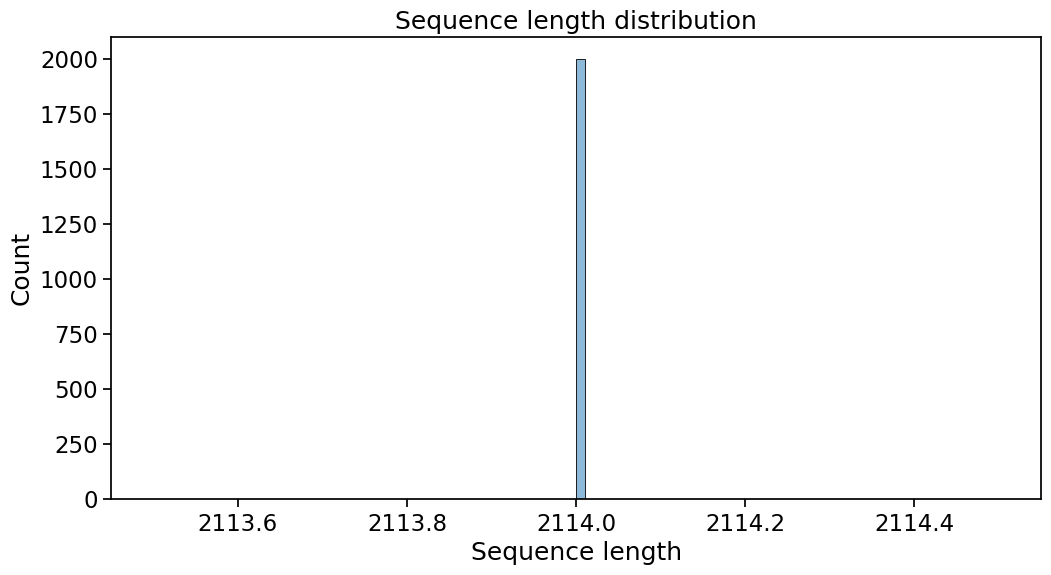

In [13]:
# Sequence length distribution
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(12, 6))
    sns.histplot(seq_df["length"], bins=100, kde=True)
    plt.xlabel("Sequence length")
    plt.ylabel("Count")
    plt.title("Sequence length distribution")
    plt.show()

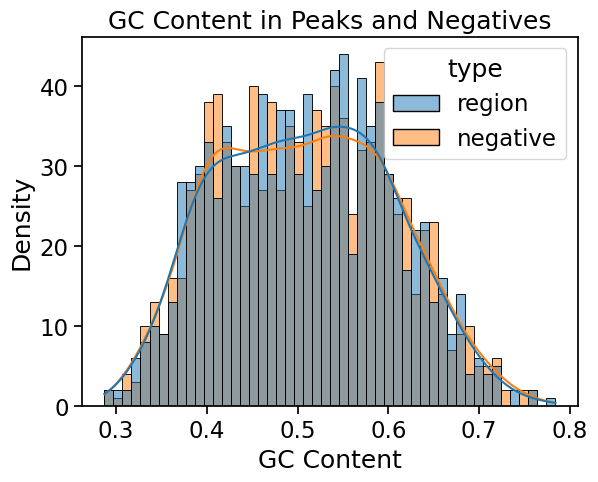

GC-bin KS test stat:0.018, p-value 0.997


In [16]:
# GC content distributions of both peaks and negatives

with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(seq_df, x="gc_percent", hue="type", bins=50, kde=True)
    plt.xlabel("GC Content")
    plt.ylabel("Density")
    plt.title("GC Content in Peaks and Negatives")
    plt.show()
loci_gc = seq_df.query("type == 'region'")["gc_percent"].values
matched_gc = seq_df.query("type == 'negative'")["gc_percent"].values
stats = ks_2samp(loci_gc, matched_gc)
print("GC-bin KS test stat:{:3.3}, p-value {:3.3}".format(stats.statistic, stats.pvalue))

In [15]:
loci_gc

array([], dtype=float64)

In [95]:
char_colors = {
    "A": "green",
    "C": "blue",
    "G": "orange",
    "T": "red",
    "non_alphabet_cnt": "grey"
}

/tmp/ipykernel_1332875/4264338060.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




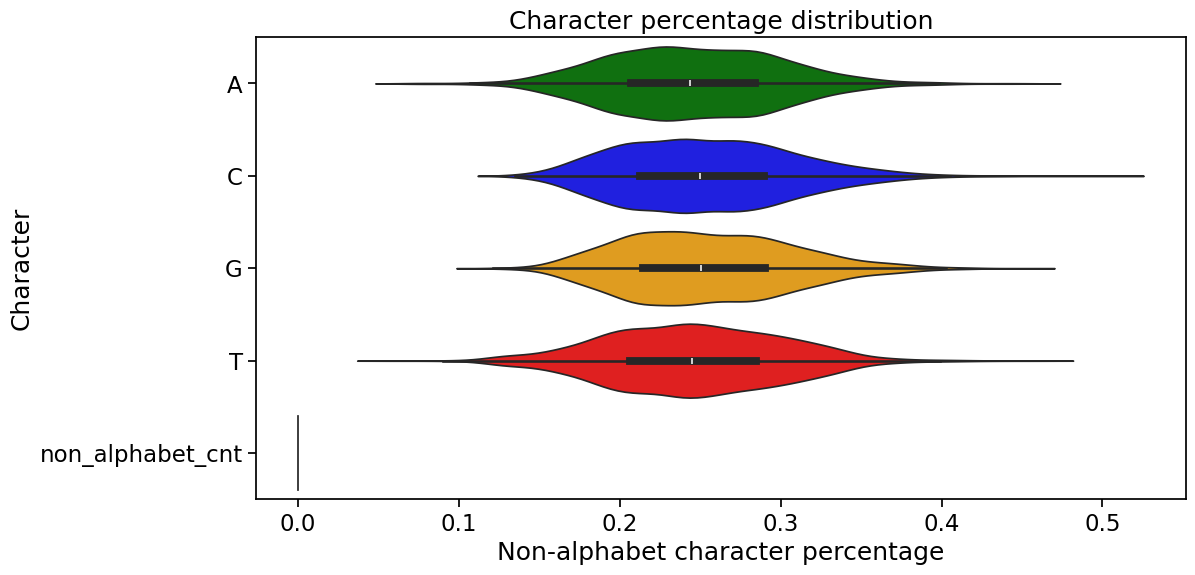

In [100]:
# Plot the distributions of characters as violin plots. The alphabet + non-alphabet characters are on the y-axis and the percentage of each character is on the x-axis.
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="value", y="variable", data=seq_df.melt(value_vars=["A", "C", "G", "T", "non_alphabet_cnt"]), palette=char_colors)
    plt.xlabel("Non-alphabet character percentage")
    plt.ylabel("Character")
    plt.title("Character percentage distribution")
    plt.show()

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10

/tmp/ipykernel_1332875/1636615809.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



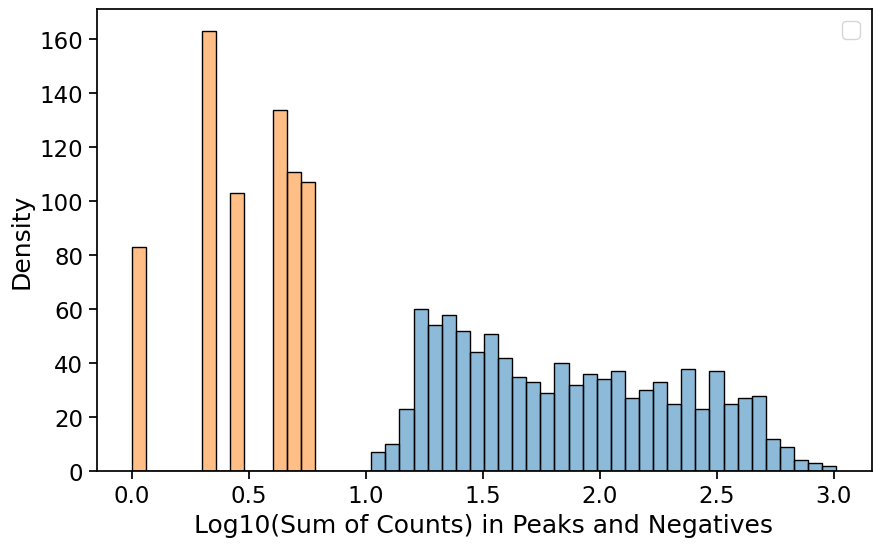

In [101]:
# total counts distribution
seq_df["log10_total_counts"] = np.log10(seq_df["total_counts"])
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.histplot(seq_df, x="log10_total_counts", hue="type", bins=50)
    plt.xlabel("Log10(Sum of Counts) in Peaks and Negatives")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [136]:
loci_df = seq_df.query("type == 'region'")
neg_df = seq_df.query("type == 'negative'")

In [137]:
max_loci = loci_df["total_counts"].max()
min_loci = loci_df["total_counts"].min()
max_neg = neg_df["total_counts"].max()
min_neg = neg_df["total_counts"].min()
print("Max loci counts: {}, Min loci counts: {}".format(max_loci, min_loci))
print("Max negative counts: {}, Min negative counts: {}".format(max_neg, min_neg))

Max loci counts: 1024.0, Min loci counts: 11.0
Max negative counts: 6.0, Min negative counts: 0.0


In [ ]:
# Suggested bias counts outlier threshold
outlier_threshold = 0.9999
upper_thresh_neg = np.quantile(neg_df["total_counts"], outlier_threshold)
lower_thresh_neg = np.quantile(neg_df["total_counts"], 1-outlier_threshold)
print("Upper threshold negative counts: {}, Lower threshold negative counts: {}".format(upper_thresh_neg, lower_thresh_neg))

Upper threshold loci counts: 1017.1069000000045, Lower threshold loci counts: 11.0
Upper threshold negative counts: 6.0, Lower threshold negative counts: 0.0


In [140]:
# Suggested bias counts loss weight
counts_loss_weight = np.median(neg_df["total_counts"][(neg_df["total_counts"] < upper_thresh_neg) & (neg_df["total_counts"] > lower_thresh_neg)])/10
counts_loss_weight

0.3

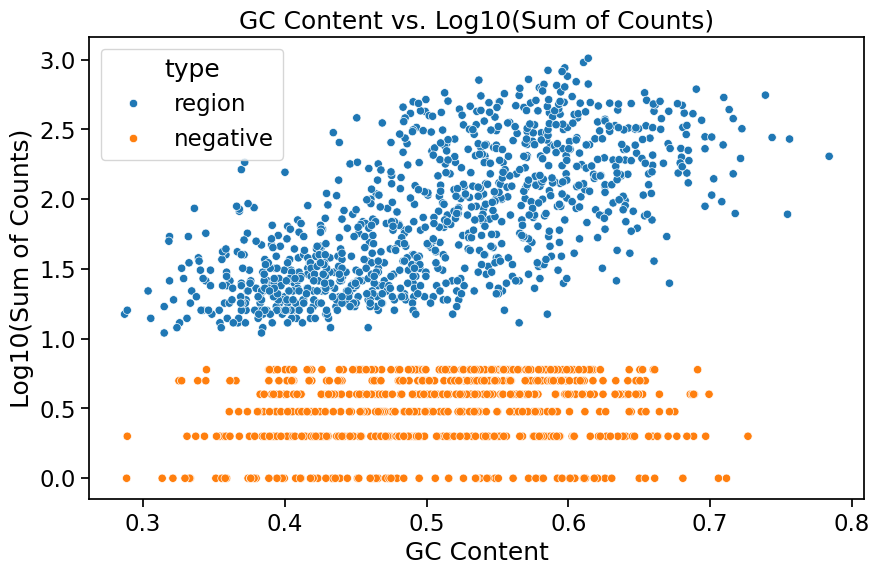

In [102]:
# Scatter plot of GC content vs. total counts
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="gc_percent", y="log10_total_counts", hue="type", data=seq_df)
    plt.xlabel("GC Content")
    plt.ylabel("Log10(Sum of Counts)")
    plt.title("GC Content vs. Log10(Sum of Counts)")
    plt.show()

In [108]:
kmer_mtx = sdata["5mer_cnt"].to_dataframe().reset_index().pivot(index="_sequence", columns="_5mer", values="5mer_cnt")

In [112]:
sorted_kmer_cnts = kmer_mtx.sum(axis=0).sort_values(ascending=False)
sorted_kmer_cnts

_5mer
CCCAG    13433
CTGGG    13358
CCTGG    12125
CCAGG    11867
CCTCC    11865
         ...  
CGATA      407
TCGTA      406
CGTAC      404
GTACG      395
TATCG      347
Length: 1024, dtype: int64

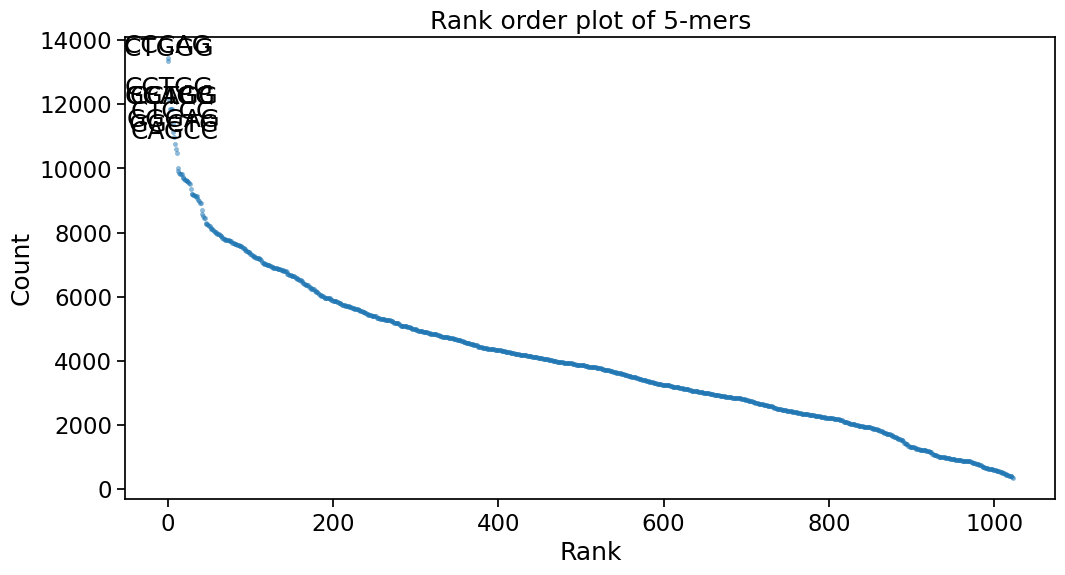

In [117]:
# Plot rank order plot of all kmers as scatter plot and label the top 10 kmers
n = 10
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=range(len(sorted_kmer_cnts)), y=sorted_kmer_cnts.values, s=10, edgecolor=None, alpha=0.5)
    for i, kmer in enumerate(sorted_kmer_cnts.index[:n]):
        plt.text(i, sorted_kmer_cnts[kmer], kmer, ha="center", va="bottom")
    plt.xlabel("Rank")
    plt.ylabel("Count")
    plt.title("Rank order plot of 5-mers")
    plt.show()

In [118]:
path_kmer_res = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/outs/SC.delta.sample.kmer_analysis.pkl"
kmer_res = pd.read_pickle(path_kmer_res)

In [127]:
kmer_res[5]

{'continuous': {'score':       5mer      corr          pval
  598  GCCCG  0.401886  4.177015e-40
  357  CCGCC  0.386337  6.059044e-37
  405  CGCCC  0.377722  2.900373e-35
  421  CGGCC  0.371928  3.665403e-34
  346  CCCGG  0.363913  1.126406e-32
  ..     ...       ...           ...
  899  TGAAT -0.235921  4.090890e-14
  59   AATGT -0.241461  9.867735e-15
  79   ACATT -0.242448  7.631775e-15
  244  ATTCA -0.242456  7.614834e-15
  254  ATTTG -0.244132  4.908917e-15
  
  [1024 rows x 3 columns]},
 'binary': {'type':       5mer       corr           pval
  490  CTGGG  3878500.0   0.000000e+00
  338  CCCAG  3874000.0   0.000000e+00
  378  CCTGG  3841500.0   0.000000e+00
  330  CCAGG  3828500.0   0.000000e+00
  936  TGGGA  3818500.0   0.000000e+00
  ..     ...        ...            ...
  396  CGATA  1378500.0   3.737515e-95
  433  CGTAC  1374500.0   1.608008e-96
  792  TACGA  1370000.0   4.579072e-98
  710  GTACG  1359500.0  1.032054e-101
  822  TATCG  1321000.0  1.307456e-115
  
  [1024 rows 

In [121]:
kmer_res[5]["binary"]["type"]

,5mer,corr,pval
490,CTGGG,3878500.0,0.000000e+00
338,CCCAG,3874000.0,0.000000e+00
378,CCTGG,3841500.0,0.000000e+00
330,CCAGG,3828500.0,0.000000e+00
936,TGGGA,3818500.0,0.000000e+00
...,...,...,...
396,CGATA,1378500.0,3.737515e-95
433,CGTAC,1374500.0,1.608008e-96
792,TACGA,1370000.0,4.579072e-98
710,GTACG,1359500.0,1.032054e-101


In [128]:
motif_mtx = sdata["motif_cnt"].to_dataframe().reset_index().pivot(index="_sequence", columns="_motif", values="motif_cnt")

In [129]:
motif_mtx

_motif,AHR.H12CORE.0.P.B,AHRR.H12CORE.0.P.C,ALX1.H12CORE.0.SM.B
_sequence,,,
negative_0,0.0,0.0,0.0
negative_1,0.0,0.0,0.0
negative_10,0.0,0.0,0.0
negative_100,1.0,0.0,0.0
negative_101,0.0,0.0,0.0
...,...,...,...
region_995,0.0,0.0,0.0
region_996,0.0,0.0,2.0
region_997,0.0,0.0,1.0


In [130]:
sorted_motif_cnts = motif_mtx.sum(axis=0).sort_values(ascending=False)
sorted_motif_cnts

_motif
ALX1.H12CORE.0.SM.B    841.0
AHR.H12CORE.0.P.B      443.0
AHRR.H12CORE.0.P.C     337.0
dtype: float64

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
from pathlib import Path
from dominate import document
from dominate.tags import h1, h2, p, img

# Function to create sequence length distribution plot
def plot_sequence_length_distribution(seq_df, output_dir):
    plt.figure(figsize=(12, 6))
    sns.histplot(seq_df["length"], bins=100, kde=True)
    plt.xlabel("Sequence length")
    plt.ylabel("Count")
    plt.title("Sequence length distribution")
    plot_path = os.path.join(output_dir, "sequence_length_distribution.png")
    plt.savefig(plot_path)
    plt.close()
    return "sequence_length_distribution.png"

# Function to create GC content distribution plot
def plot_gc_content_distribution(seq_df, output_dir):
    plt.figure(figsize=(12, 6))
    sns.histplot(seq_df, x="gc_percent", hue="type", bins=50, kde=True)
    plt.xlabel("GC Content")
    plt.ylabel("Density")
    plt.title("GC Content in Peaks and Negatives")
    plot_path = os.path.join(output_dir, "gc_content_distribution.png")
    plt.savefig(plot_path)
    plt.close()
    return "gc_content_distribution.png"

# Function to compute KS statistics for GC content
def compute_gc_content_ks_test(seq_df):
    loci_gc = seq_df.query("type == 'peak'")["gc_percent"].values
    matched_gc = seq_df.query("type == 'negative'")["gc_percent"].values
    stats = ks_2samp(loci_gc, matched_gc)
    return stats

# Function to create character percentage distribution plot
def plot_character_distribution(seq_df, output_dir):
    char_colors = {
        "A": "green",
        "C": "blue",
        "G": "orange",
        "T": "red",
        "non_alphabet_cnt": "grey"
    }
    plt.figure(figsize=(12, 6))
    melted_df = seq_df.melt(value_vars=["A", "C", "G", "T", "non_alphabet_cnt"])
    sns.violinplot(x="value", y="variable", data=melted_df, palette=char_colors)
    plt.xlabel("Non-alphabet character percentage")
    plt.ylabel("Character")
    plt.title("Character percentage distribution")
    plot_path = os.path.join(output_dir, "character_distribution.png")
    plt.savefig(plot_path)
    plt.close()
    return "character_distribution.png"

# Function to create total counts distribution plot
def plot_total_counts_distribution(seq_df, output_dir):
    seq_df["log10_total_counts"] = np.log10(seq_df["total_counts"])
    plt.figure(figsize=(10, 6))
    sns.histplot(seq_df, x="log10_total_counts", hue="type", bins=50)
    plt.xlabel("Log10(Sum of Counts) in Peaks and Negatives")
    plt.ylabel("Density")
    plt.title("Total Counts Distribution")
    plot_path = os.path.join(output_dir, "total_counts_distribution.png")
    plt.savefig(plot_path)
    plt.close()
    return "total_counts_distribution.png"

# Function to compute statistics for total counts
def compute_total_counts_stats(seq_df):
    loci_df = seq_df.query("type == 'region'")
    neg_df = seq_df.query("type == 'negative'")
    max_loci = loci_df["total_counts"].max()
    min_loci = loci_df["total_counts"].min()
    max_neg = neg_df["total_counts"].max()
    min_neg = neg_df["total_counts"].min()
    outlier_threshold = 0.9999
    upper_thresh_neg = np.quantile(neg_df["total_counts"], outlier_threshold)
    lower_thresh_neg = np.quantile(neg_df["total_counts"], 1 - outlier_threshold)
    counts_loss_weight = np.median(
        neg_df["total_counts"][
            (neg_df["total_counts"] < upper_thresh_neg) & (neg_df["total_counts"] > lower_thresh_neg)
        ]
    ) / 10
    return {
        "max_loci": max_loci,
        "min_loci": min_loci,
        "max_neg": max_neg,
        "min_neg": min_neg,
        "upper_thresh_neg": upper_thresh_neg,
        "lower_thresh_neg": lower_thresh_neg,
        "counts_loss_weight": counts_loss_weight
    }

# Function to create GC content vs. total counts scatter plot
def plot_gc_vs_total_counts(seq_df, output_dir):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="gc_percent", y="log10_total_counts", hue="type", data=seq_df)
    plt.xlabel("GC Content")
    plt.ylabel("Log10(Sum of Counts)")
    plt.title("GC Content vs. Log10(Sum of Counts)")
    plot_path = "gc_vs_total_counts.png"
    plt.savefig(plot_path)
    plt.close()
    return "gc_vs_total_counts.png"

# Master function to generate HTML report
def generate_html_report(seq_df, output_dir="report_output"):
    Path(output_dir).mkdir(exist_ok=True)
    
    length_plot = plot_sequence_length_distribution(seq_df, output_dir)
    gc_plot = plot_gc_content_distribution(seq_df, output_dir)
    gc_stats = compute_gc_content_ks_test(seq_df)
    char_plot = plot_character_distribution(seq_df, output_dir)
    total_counts_plot = plot_total_counts_distribution(seq_df, output_dir)
    total_counts_stats = compute_total_counts_stats(seq_df)
    scatter_plot = plot_gc_vs_total_counts(seq_df, output_dir)
    
    report_path = os.path.join(output_dir, "report.html")
    with document(title="Sequence Analysis Report") as doc:
        h1("Sequence Analysis Report")
        
        h2("1. Sequence Length Distribution")
        img(src=length_plot, width="600px")
        
        h2("2. GC Content Distribution")
        img(src=gc_plot, width="600px")
        p(f"KS Test Statistic: {gc_stats.statistic:.3f}, p-value: {gc_stats.pvalue:.3g}")
        
        h2("3. Character Percentage Distribution")
        img(src=char_plot, width="600px")
        
        h2("4. Total Counts Distribution")
        img(src=total_counts_plot, width="600px")
        p(f"Max Loci Counts: {total_counts_stats['max_loci']}, Min Loci Counts: {total_counts_stats['min_loci']}")
        p(f"Max Negative Counts: {total_counts_stats['max_neg']}, Min Negative Counts: {total_counts_stats['min_neg']}")
        p(f"Upper Threshold Negative Counts: {total_counts_stats['upper_thresh_neg']}, "
          f"Lower Threshold Negative Counts: {total_counts_stats['lower_thresh_neg']}")
        p(f"Suggested Bias Counts Loss Weight: {total_counts_stats['counts_loss_weight']:.3f}")
        
        h2("5. GC Content vs. Log10(Sum of Counts)")
        img(src=scatter_plot, width="600px")
    
    with open(report_path, "w") as f:
        f.write(doc.render())
    
    print(f"Report generated at: {report_path}")
    return report_path


In [18]:
generate_html_report(seq_df, output_dir=path_out)

/tmp/ipykernel_1670085/3019878733.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="value", y="variable", data=melted_df, palette=char_colors)
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Report generated at: /cellar/users/aklie/projects/ML4GLand/EUGENe/examples/report/SC.delta/outs/report.html


'/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/report/SC.delta/outs/report.html'